In this notebook, I show an example of training a template on a data set. This notebook contains the template perturbation algorithm so that I can lower the value of $\Delta_k$ for slower training (to show a gradual progression in the example training plot).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, copy

from modules import get_bandpass_dict, get_eff_wavelen, get_bandpass_functions, Sed

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')

Load one of the CWW+SB4 templates:

In [3]:
name = 'templates/ssp_5Myr_z008.sed'
x,y = np.loadtxt(name,unpack=True)
x /= 10 # convert wavelengths Angstroms -> nm
sed = Sed()
sed.wavelen = x
sed.flambda = y
#sed.flambdaTofnu()
del x,y

In [4]:
bandpass_dict = get_bandpass_dict(filter_loc='filters/')

Create a set of redshifted photometry

In [5]:
photometry = []
#bandpass_dict = get_bandpass_dict()
filters = list(bandpass_dict.keys())
random.seed(11)
for i in range(200):
    sed_ = copy.deepcopy(sed)
    redshift = np.random.rand()*5
    sed_.redshift(redshift)
    eff_wavelen = get_eff_wavelen(bandpass_dict)
    wavelen = eff_wavelen/(1+redshift)
    
    fluxes = sed_.fluxlist(bandpass_dict)
    fluxes = [random.gauss(i,0.1*i) for i in fluxes]
    
    for i in range(len(wavelen)):
        photometry.append([wavelen[i],fluxes[i],0.1,redshift,filters[i]])

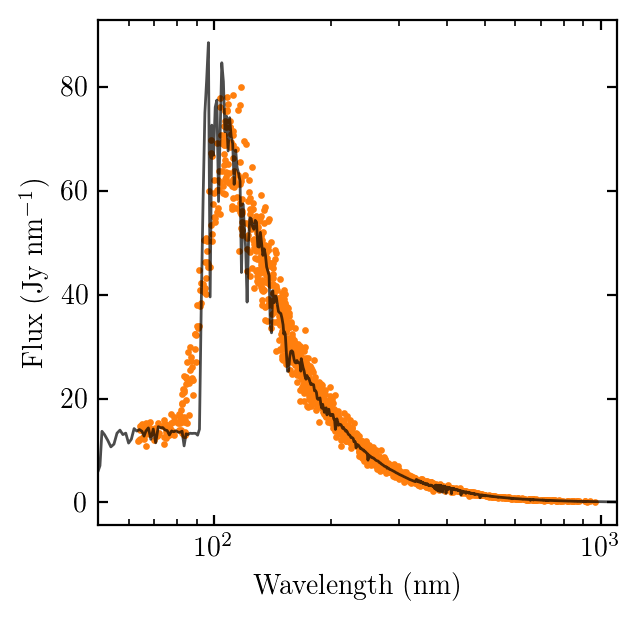

In [6]:
# plot photometry
wavelen = [i[0] for i in photometry]
flux  = [i[1] for i in photometry]
plt.scatter(wavelen,flux,c='C1',s=2)

# plot original template
plt.plot(sed.wavelen,sed.flambda,c='k',lw=1,alpha=0.7)

plt.xlim(50,1100)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (Jy nm$^{-1}$)")
plt.xscale('log')
plt.show()

Here is the algorithm to perturb a template

In [8]:
# pull in the filter functions that are defined in modules.py
bandpass_functions = get_bandpass_functions(bandpass_dict)

def perturb_template(template,photometry,mask=0):
    """
    Function that perturbs an SED template in accordance with the
    matched photometry. Definition of terms found in paper I am writing.
    """
    
    nbins = len(template.wavelen)
    wavelen = template.wavelen
    widths = [float(wavelen[1]-wavelen[0]),
              *[(wavelen[i+1]-wavelen[i-1])/2 for i in range(1,nbins-1)],
              float(wavelen[-1]-wavelen[-2])]
    
    # create initial M and nu
    Delta = 0.01
    M = np.identity(nbins)*1/Delta**2
    nu = np.zeros(nbins)
    
    # if no mask is given, use all data
    if type(mask) == int:
        mask = np.ones(len(photometry))
    
    # run through all the photometry
    for i,row in enumerate(photometry):
        
        # skip this row if it's an outlier
        if mask[i] == -1:
            continue
            
        # get observed flux
        obs_flux = row[1]
        sigma = row[2]
        
        # calculate template flux
        redshift = row[3]
        filter_name = row[4]
        template_ = copy.deepcopy(template)
        template_.redshift(redshift)
        template_flux = template_.flux(bandpass_dict[filter_name])
        
        #filter_wavelen = row[0]*(1+redshift)
        
        # calculate r^n * Delta lambda
        bandpass_func = bandpass_functions[filter_name]
        rn_dlambda = bandpass_func( wavelen * (1+redshift) ) * widths * (1+redshift)
        
        # add to M
        M += 1/sigma**2 * np.outer(rn_dlambda,rn_dlambda)
        
        # add to nu
        nu += 1/sigma**2 * (obs_flux - template_flux) * rn_dlambda
    
        
    # solve the system for the perturbation    
    sol = np.linalg.solve(M,nu)
    return sol

Create a naive template

In [9]:
template = Sed()
template.wavelen = np.geomspace(10,1150,200)
template.flambda = 0*template.wavelen + 5.0
#template.flambdaTofnu()

And perturb it 100 times

In [10]:
%%time
history = dict()
save = [1,5,10,20,30,40,50,60,70,80,90,100]
new_template = copy.deepcopy(template)
for i in range(100):
    sol = perturb_template(new_template,photometry)
    new_template.flambda += sol
    if i + 1 in save:
        history[i+1] = copy.deepcopy(new_template)

CPU times: user 14min 39s, sys: 52.1 s, total: 15min 31s
Wall time: 36 s


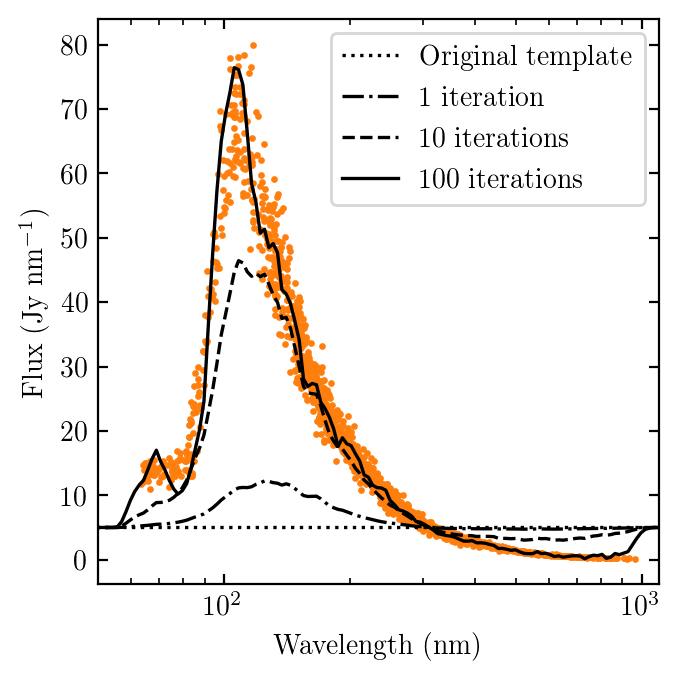

In [11]:
fig,ax = plt.subplots()

# plot the photometry
wavelen = [i[0] for i in photometry]
flux  = [i[1] for i in photometry]
ax.scatter(wavelen,flux,c='C1',s=2)

# plot different stages of training
ax.plot(template.wavelen,template.flambda,label='Original template',c='k',ls=':')
ax.plot(history[1].wavelen,history[1].flambda,label='1 iteration',c='k',ls='-.')
ax.plot(history[10].wavelen,history[10].flambda,label='10 iterations',c='k',ls='--')
ax.plot(history[100].wavelen,history[100].flambda,label='100 iterations',c='k',ls='-')

ax.legend()

ax.set_xlim(50,1100)
#ax.set_ylim(-5,90)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux (Jy nm$^{-1}$)")
plt.xscale('log')

plt.tight_layout(pad=0.5)
#fig.savefig('plots/training_example.pdf')